In [1]:
!pip install geopandas matplotlib contextily folium

  Using cached folium-0.20.0-py2.py3-none-any.whl.metadata (4.2 kB)
Using cached folium-0.20.0-py2.py3-none-any.whl (113 kB)



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\vimed\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UnicodeWarning)
import pandas as pd
# leitura dos dataset 
df_peso = pd.read_stata(r'C:\Users\vimed\Downloads\banco_ISA_Vinicius (1).dta')
df = pd.read_csv(r'C:\Users\vimed\Downloads\Data_Set_para_Contrafactuais.csv')
#juncao dos dataset necessarios
df = df.merge(df_peso,right_on='id_original', left_on='id', how='inner')

In [ ]:
def remover_datas_invalidas(df, coluna="datanasc"): # funcao de conversao de datas para datetime pandas
# em caso de não conseguir fazer a conversao, converter para NAT, do erro
    df[coluna] = pd.to_datetime(df[coluna], dayfirst=True, errors='coerce')
# limpeza do nat
    df = df.dropna(subset=[coluna]).reset_index(drop=True)

    return df
# aplicação da funcao
df = remover_datas_invalidas(df)


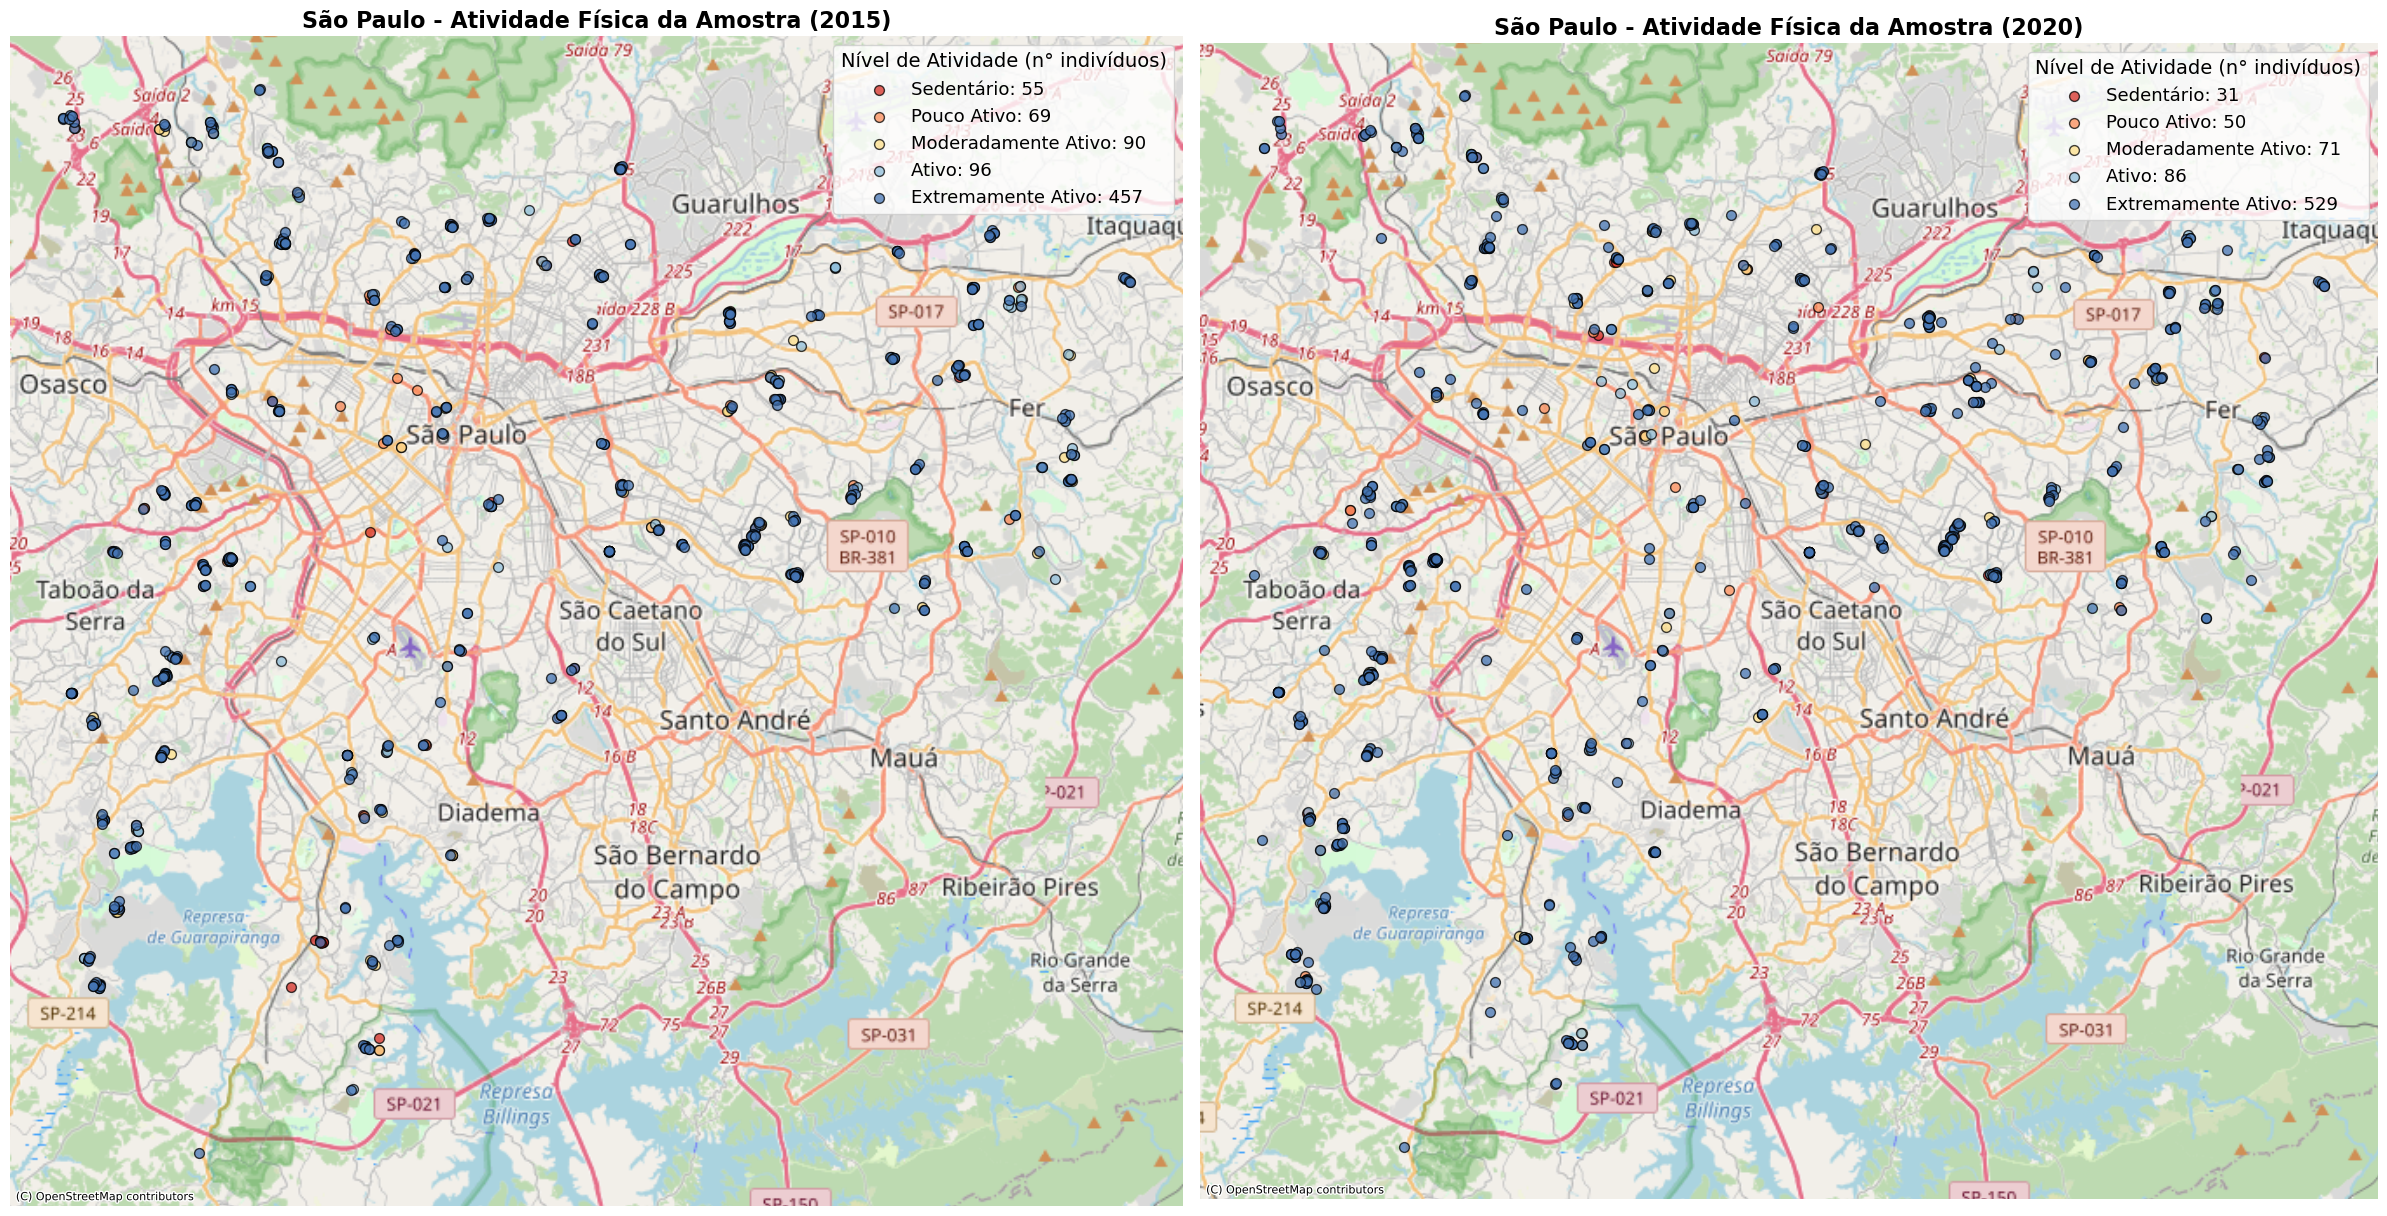

In [ ]:
import pandas as pd, matplotlib.pyplot as plt, contextily as ctx, geopandas as gpd
from shapely.geometry import Point
# limpeza das linhas ausentes ou vazias, caso tenha
df_map = df.dropna(subset=["lat2015","long2015","AFTOTAL1","lat2020","long2020","AFTOTAL2"]).copy()
# funcao de classificao dos minutos em nivel de atividade fisica
def classificar_atividade(m):
    if m <= 0: return "Sedentário"
    elif m < 150: return "Pouco Ativo"
    elif m < 300: return "Moderadamente Ativo"
    elif m < 450: return "Ativo"
    else: return "Extremamente Ativo"
# paleta de cores utilizadas para cada classificacao 
cores = {"Sedentário":"#d73027","Pouco Ativo":"#fc8d59","Moderadamente Ativo":"#fee08b",
         "Ativo":"#91bfdb","Extremamente Ativo":"#4575b4"}
#plotagem dos mapas
def mapa(df, lat, lon, minutos, titulo, ax):
    #conversao do dataframe para Geodataframe e transformacao via Geomarcador via documentacao geopandas
    gdf = gpd.GeoDataFrame(df, geometry=[Point(xy) for xy in zip(df[lon], df[lat])], crs="EPSG:4326").to_crs(3857)
    #insercao de uma coluna sobre a classificao do nivel de atividade fisica
    gdf["cat"] = gdf[minutos].apply(classificar_atividade)
    #plote com as cores e as categorias associadas
    for c, cor in cores.items():
        s = gdf[gdf["cat"] == c]
        if not s.empty:
            s.plot(ax=ax, markersize=50, color=cor, alpha=.75, edgecolor="black", label=f"{c}: {len(s)}")
            #adicao do mapa por pano de fundo via openstreepmap que nao possui licença
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    ax.set_axis_off()
    ax.legend(title="Nível de Atividade (n° indivíduos)", loc="upper right", fontsize=13, title_fontsize=14)
    ax.set_title(titulo, fontsize=16, fontweight="bold")
#plote dos mapas
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
mapa(df_map,"lat2015","long2015","AFTOTAL1","São Paulo - Atividade Física da Amostra (2015)",ax[0])
mapa(df_map,"lat2020","long2020","AFTOTAL2","São Paulo - Atividade Física da Amostra (2020)",ax[1])
plt.tight_layout()
plt.show()


# Dados Geograficos da CET

In [ ]:
import geopandas as gpd

# carrega os dados via geopanadas
caminho = r"C:\Users\vimed\Downloads\shapesInfraestruturaCicloviaria\CicloviasConexoes.shp"
gdf = gpd.read_file(caminho)

# reorganizacao e estruturacao  via geopandas  georeferenciador via documentacao geopanadas
#https://geopandas.org/en/stable/docs/user_guide/projections.html
if not isinstance(gdf, gpd.GeoDataFrame):
    gdf = gpd.GeoDataFrame(gdf, geometry='geometry')
gdf = gdf.set_crs(epsg=4326) if gdf.crs is None else gdf
gdf = gdf.to_crs(epsg=3857)

# Filtra o tipo da ciclovia
ciclovias = gdf[gdf['tipo'].str.contains('CICLO', case=False, na=False)].copy()
ciclovias['extensao_km'] = ciclovias.length / 1000

#  analise as ciclovias quanto aa extensao em km
def analisar_ciclovias(gdf):
    print("\n" + "=")
    print("Analise das Ciclovias")
    print("=")
    
    print(f"\nSegmentos: {len(gdf)}")
    print(f"Extensão total: {gdf['extensao_km'].sum():.2f} km")
    
    # os tipos de ciclovias
    print("\nTipos (por segmentos):") #top 20
    for tipo, count in gdf['tipo'].value_counts().head(20).items():
        print(f"  {tipo}: {count}")
    
    print("\nTipos (por extensão):") #top 20  tipo por ordem decrescente
    for tipo, km in gdf.groupby('tipo')['extensao_km'].sum().sort_values(ascending=False).head(20).items():
        print(f"  {tipo}: {km:.2f} km")
    
    # Subprefeituras onde estao distribuidas via segmentos
    if 'subprefeitu' in gdf.columns:
        print(f"\nSubprefeituras: {gdf['subprefeitu'].nunique()}")
        
        print("\nSubprefeituras (por segmentos):")# elencando as top 20 por segmento por ordem descrecente
        for subpref, count in gdf['subprefeitu'].value_counts().head(20).items():
            print(f"  {subpref}: {count}")
        
        print("\nSubprefeituras (por extensão):") #  as top 20 por extensao por ordem descrecente
        for subpref, km in gdf.groupby('subprefeitu')['extensao_km'].sum().sort_values(ascending=False).head(20).items():
            print(f"  {subpref}: {km:.2f} km")

analisar_ciclovias(ciclovias)


=
Analise das Ciclovias
=

Segmentos: 122
Extensão total: 80.70 km

Tipos (por segmentos):
  CICLOFAIXA: 76
  CICLOVIA: 24
  CICLOVIA/PASSEIO: 7
  CICLOVIA NO BORDO DA PISTA/CICLOFAIXA NO CANTEIRO: 6
  CICLOVIA PASSEIO: 5
  CICLOVIA NO PASSEIO: 3
  CICLOFAIXA/CICLOVIA/PASSEIO: 1

Tipos (por extensão):
  CICLOFAIXA: 50.62 km
  CICLOVIA: 17.03 km
  CICLOVIA NO BORDO DA PISTA/CICLOFAIXA NO CANTEIRO: 4.29 km
  CICLOFAIXA/CICLOVIA/PASSEIO: 2.63 km
  CICLOVIA/PASSEIO: 2.59 km
  CICLOVIA NO PASSEIO: 2.10 km
  CICLOVIA PASSEIO: 1.43 km

Subprefeituras: 20

Subprefeituras (por segmentos):
  IPIRANGA: 21
  LAPA: 17
  VILA MARIANA: 13
  VILA PRUDENTE: 13
  PIRITUBA-JARAGUA: 11
  FREGUESIA-BRASILANDIA: 9
  SE: 9
  JABAQUARA: 5
  MOOCA: 5
  SANTO AMARO: 4
  ITAQUERA: 3
  CAMPO LIMPO: 3
  ARTUR ALVIM: 2
  SANTANA-TUCURUVI: 1
  M'BOI MIRIM: 1
  CASA VERDE-CACHOEIRINHA: 1
  VILA MARIA-VILA GUILHERME: 1
  PINHEIROS: 1
  CIDADE ADEMAR: 1
  ERMELINO MATARAZZO: 1

Subprefeituras (por extensão):
  IPIRANG

Sistema de coordenadas: None
Colunas : ['programa', 'inauguracao', 'extensao_t', 'extensao_c', 'geometry']
Tipos de infraestrutura: Coluna tipo não encontrada


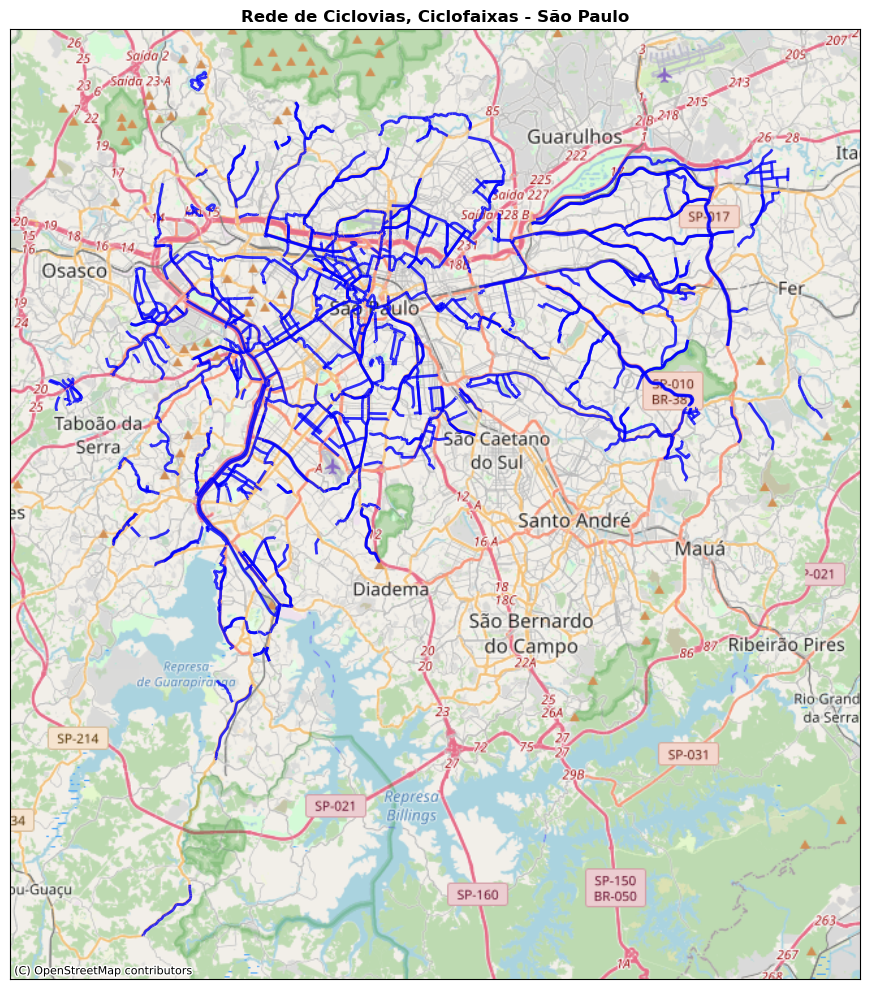


Total de segmentos: 2299


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import box

#  caregamento do dataframe associado
caminho = r"C:\Users\vimed\Downloads\shapesInfraestruturaCicloviaria\Ciclovias.shp"


gdf = gpd.read_file(caminho)

#conversao para geodataframe via geopandas
if not isinstance(gdf, gpd.GeoDataFrame):
    gdf = gpd.GeoDataFrame(gdf, geometry='geometry')


print(f"Sistema de coordenadas: {gdf.crs}")

# reorganizacao e estruturacao  via geopandas  georeferenciador via documentacao geopanadas
#https://geopandas.org/en/stable/docs/user_guide/projections.html
if gdf.crs is None:
    gdf = gdf.set_crs(epsg=4326)
gdf = gdf.to_crs(epsg=3857)

# colunas usadas para tal
print(f"Colunas : {gdf.columns.tolist()}")
print(f"Tipos de infraestrutura: {gdf['tipo'].unique() if 'tipo' in gdf.columns else 'Coluna tipo não encontrada'}")

# criacao do grafico
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

#  usado inlcuindo ciclovias e ciclofaixas
if 'tipo' in gdf.columns:
    # Mapear cores para cada tipo
    cores = {
        'CICLOFAIXA': '#33a02c',
        'CICLOVIA': '#33a02c',
    }
    
    # Plotagem dos tipos
    for tipo in gdf['tipo'].unique():
        if tipo in cores:
            subset = gdf[gdf['tipo'] == tipo]
            subset.plot(ax=ax, color=cores[tipo], label=tipo, linewidth=2, alpha=0.8)
        else:
            subset = gdf[gdf['tipo'] == tipo]
            subset.plot(ax=ax, label=tipo, linewidth=2, alpha=0.8)
    
    plt.legend(title='Tipo de Infraestrutura')
else:
  
    gdf.plot(ax=ax, color='blue', linewidth=2, alpha=0.8)

# #adicao do mapa de sp em openstreetmap juntamente com tratamento de erros 
try:
    ctx.add_basemap(ax, crs=gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik)
except Exception as e:
    print(f"Erro : {e}")
    try:
        ctx.add_basemap(ax, crs=gdf.crs, source=ctx.providers.Stamen.TonerLite)
    except Exception as e2:
        print(f"Erro : {e2}")
#limpar demarcadores
ax.set_xticks([]) 
ax.set_yticks([])  
ax.set_xlabel('') 
ax.set_ylabel('')  #

# titulo do mapa  usado open street
plt.title('Rede de Ciclovias, Ciclofaixas - São Paulo', fontsize=12, fontweight='bold')
plt.tight_layout()

# plot do grafico
plt.show()

# dados de estatitistica
print(f"\nTotal de segmentos: {len(gdf)}")
if 'tipo' in gdf.columns:
    print("\nDistribuição por tipo:")
    print(gdf['tipo'].value_counts())

# Plot dos Paraciclos/Bicicletarios

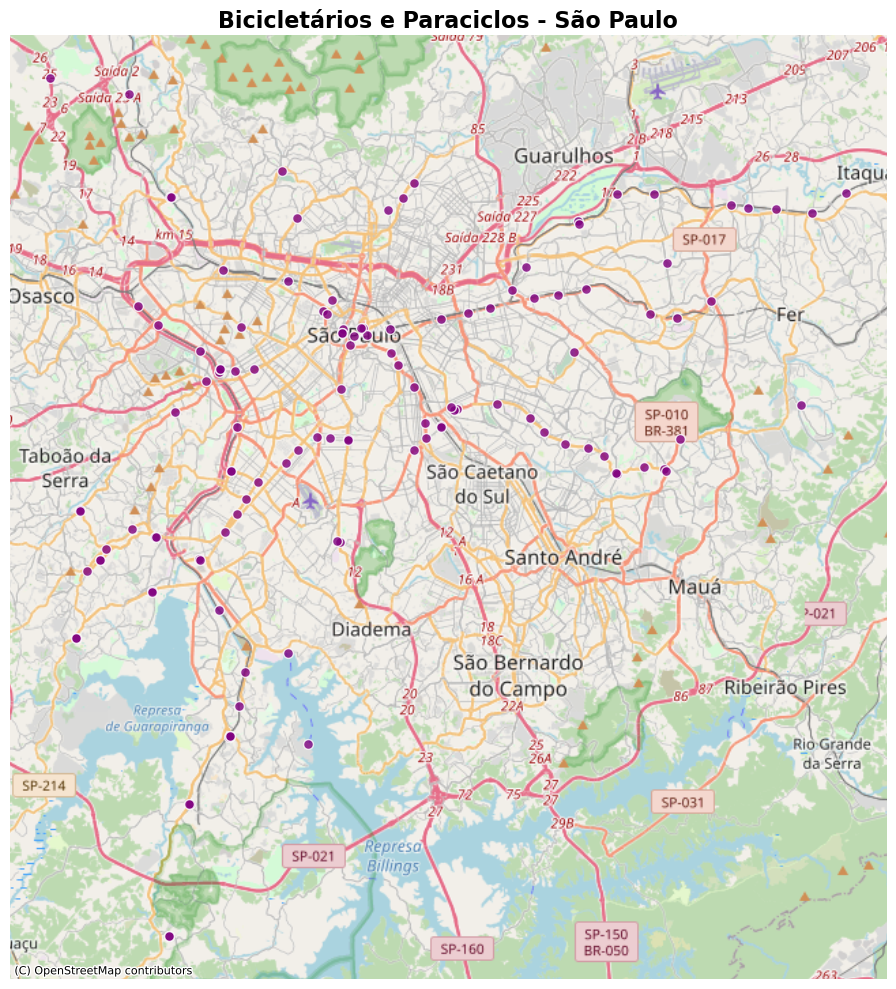

Total plotado: 123 bicicletários/paraciclos em roxo


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Carregar dados
caminho = r"C:\Users\vimed\Downloads\shapesInfraestruturaCicloviaria (3)\BicicletariosParaciclos.shp"
gdf = gpd.read_file(caminho)

# Configurar do geopadas via documentacao supracitada
if gdf.crs is None:
    gdf = gdf.set_crs(epsg=4326)
gdf = gdf.to_crs(epsg=3857)

# plot dos pontos
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf.plot(ax=ax, color='purple', markersize=50, alpha=0.8, edgecolor='white', linewidth=1)

# mapa de sao paulo  via openstreet mapa
ctx.add_basemap(ax, crs=gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik)

# plotagem
ax.axis('off')
plt.title('Bicicletários e Paraciclos - São Paulo', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Total plotado: {len(gdf)} bicicletários/paraciclos em roxo")